# Clusters by use of time
### Lara Hronn Petursdottir - Udacity Capstone project
---
## Table of contents
1. [Introduction](#introduction)
2. [Data](#data)
3. [Find the Clusters](#find_clusters)
    1. [Dimensionality Reduction](#dimred)
    2. [Apply t-SNE and bh-SNE](#sne) 
    3. [Clustering with KMeans and GMM](#clust)
    4. [Plottin](#plott) 
4. [Bigger data](#big) 
5. [Conclusion](#conclu)
6. [References](#ref)
---

# Introduction <a name='introduction'></a>
Can we use unsupervised learning and clustering to divide people into groups based on how they spend their days? The first part of the problem is to find if it is possible in general to categorize people in this way. The second part is to find how many groups there would be and how they interact with each other. To get to better know the dataset, the `data_basic_vis.ipynb` describes the data and has some visual demonstrations. It is recommended to explore `data_basic_vis.ipynb` before continuing with this project.

We will be using two methods, t-SNE and bh-SNE. Originally this project was supposed to use only t-SNE but further research resulted in the use of bh-SNE. T-SNE is an effective mean for dimension reduction but compared to bh-SNE it is computationally heavy (running in O(n^2) time). Barnes-Hut t-Distributed Stochastic Neighbour Embedding (BH-SNE) runs in O(n log n) time and is an effective means of quick dimension reduction with little loss in fidelity.

### What next?
- Import the functions we need
- Load the dataset
- Use TruncatedSVD for dimensionality reduction to make it into a surprisingly informative smaller matrix
- Use KMeans to group our participants into some clusters
- Use t-SNE and bh-SNE to get coordinates for a scatterplot
- Visualize the results

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture as GMM
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

from tsne import bh_sne
import time

import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('larahronn', 'q0elyG72UjPe0L3NlUv3')

%matplotlib inline

---
# Data <a name='data'></a>
The American Time Use Survey (ATUS) is the Nation’s first federally administered, continuous survey on time use in the United States. The goal of the survey is to measure how people divide their time (in minutes) among life’s activities. Our data comes from the ATUS dataset from the year 2003 to 2015, it has been cleaned and formatted in `atus_data_cleanup.ipynb`

We start by importing our datasets. We will import the full `big_data` sets that contain all the time entries from the 170,842 participants to run the final algorithm on. To use for our time measurement, calculations and trials we will import both the `s5` and `s10` datasets where we have taken a sample of 5,000 and 10,000 participants. 

We will also import `the_data` data set where the time entries have been manually merged from 431 features to 83 features. This will give us a different perspective  on the data.

In [2]:
big_data = pd.read_csv('big_data.csv')
s10_big_data = pd.read_csv('s10big_data.csv')
the_data = pd.read_csv('the_data.csv')
s10_the_data = pd.read_csv('s10_the_data.csv')
index = s10_big_data.index.values

print 'You have successfully imported the data.'

You have successfully imported the data.


---
# Find the clusters <a name='find_clusters')></a>
We have successfully imported the data. Now we are going to see if we can actually cluster the respondents and divide them into some sort of groups or clusters. **Let's get started...**

**Should we center the matrix?**

Centring sparse data would destroy the sparseness structure in the data, and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, especially if features are on different scales. In our case the data is all in minutes (same scale) and we will not centre the matrix.

---

## Dimensionality reduction <a name='dimred'></a>
In this part we will use both the manually merged data `the_data` (td) and the `big_data` (bd) (where the data points have not been manually merged) and dimensionality reduce (dr) the data sets. While this is most likely a non-linear problem we will use TruncatedSVD instead of the popular PCA. Because of the sparseness of the data (88% and 97% - calculated in `data_basic_vis`) we will use the ARPACK wrapper (scipy.sparse.linalg.svds) with the TruncatedSVD.

In [135]:
%%time
# Gives us vital information about the processing time

#Create the dimensionality reduction component
svd = TruncatedSVD(algorithm='arpack', n_components=100)

#Apply the dimensionality reduction component and normalize the outcome
dr_bd10 = normalize(svd.fit_transform(s10_big_data), norm='l1')

CPU times: user 2.35 s, sys: 201 ms, total: 2.55 s
Wall time: 2.5 s


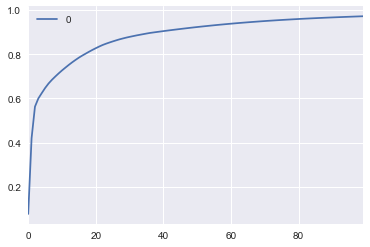

In [136]:
#Visualization for the relationship between components and how much of the variance it captures.
pd.DataFrame(np.cumsum(svd.explained_variance_ratio_)).plot()

### Observation
It seems like we can compress the 431 features into 100 components loosing less than 5% variance. We are not gaining too much after the first 40 components (maintaining about 90% of the variance) and only 2 componoents would be giving us about 60% of the variance.

In [137]:
%%time

svd1 = TruncatedSVD(algorithm='arpack', n_components=5)
dr_td10 = normalize(svd1.fit_transform(s10_the_data), norm='l1')

CPU times: user 89.3 ms, sys: 22.3 ms, total: 112 ms
Wall time: 257 ms


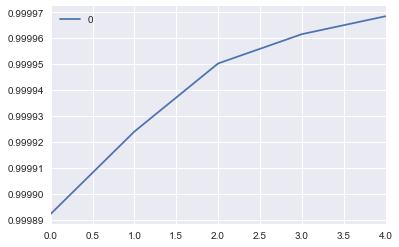

In [138]:
pd.DataFrame(np.cumsum(svd1.explained_variance_ratio_)).plot()

### Observation
It seems like we can compress the 83 features into 2 components loosing less than 0.00005% variance.

---

## Apply t-SNE and bh-SNE <a name='sne'></a>

Now we´ll run two kind of embedding techniques to get coordinates for our scatterplots, the t-SNE and the bh-SNE. The t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. The bh-SNE uses vantage-point trees to compute sparse pairwise similarities between the input data objects, and it uses a variant of the Barnes-Hut algorithm to approximate the forces between the corresponding points in the embedding.

Former experiments have shown that bh-SNE (normally runs in O(N log N)) leads to substantial computational advantages over standard t-SNE (normally runs in O(N2) which makes it more suitable for bigger datasets.

### t-SNE with SVD

In [194]:
%%time

dr_tbd10_result = TSNE(n_components=2, random_state=0).fit_transform(dr_bd10)

CPU times: user 4min 54s, sys: 1min 25s, total: 6min 19s
Wall time: 7min 3s


In [187]:
%%time

dr_tbd10raw_result = TSNE(n_components=2, random_state=0).fit_transform(s10_big_data)

CPU times: user 5min 45s, sys: 2min 6s, total: 7min 52s
Wall time: 9min 16s


### bh-SNE with SVD

In [189]:
%%time

dr_bhbd10_result = bh_sne(dr_bd10, perplexity=40)

CPU times: user 1min 23s, sys: 1.53 s, total: 1min 24s
Wall time: 1min 26s


### bh-SNE directly 

In [142]:
%%time

bhbd10_result = bh_sne(s10_big_data)

CPU times: user 1min 29s, sys: 2.21 s, total: 1min 32s
Wall time: 1min 37s


### t-SNE with SVD on data on manually merged data

In [143]:
%%time

dr_ttd10_result = TSNE(n_components=2, random_state=0).fit_transform(dr_td10)

CPU times: user 3min 47s, sys: 1min 20s, total: 5min 8s
Wall time: 5min 30s


### bh-SNE with SVD on data on manually merged data

In [144]:
%%time

dr_bhtd10_result = bh_sne(dr_td10)

CPU times: user 59.5 s, sys: 718 ms, total: 1min
Wall time: 1min 1s


### bh-SNE directly on manually merged data

In [145]:
%%time

bhtd10_result = bh_sne(s10_the_data)

CPU times: user 1min 8s, sys: 1.97 s, total: 1min 10s
Wall time: 1min 26s


### Observation
We can clearly see that t-SNE with SVD requires significantly more Wall time than bh-SNE with and without SVD. Lets see what gives us the best clustering results.

---

## Clustering with KMeans and GMM<a name='clust'></a>

We will run a silhouette_score to decide the number of clusters by using KMeans and GaussianMixture (GMM).

### KMeans - `big_data` with dimentionality reduction and t-SNE

In [25]:
#Go through with different n_components to find the best silhouette score
cluster_range = list(range(2,10)) 

for n_cluster in cluster_range: 
    # Apply the clustering algorithm 
    clusterer = KMeans(n_cluster, random_state=2).fit(dr_tbd10_result) 
    
    # Predict the cluster for each data point
    preds = clusterer.predict(dr_tbd10_result)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(dr_tbd10_result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.380812336092
The score for n_cluster = 3. is : 0.40825084319
The score for n_cluster = 4. is : 0.3949690801
The score for n_cluster = 5. is : 0.358880376937
The score for n_cluster = 6. is : 0.350632889473
The score for n_cluster = 7. is : 0.365772049311
The score for n_cluster = 8. is : 0.35416409182
The score for n_cluster = 9. is : 0.359954368027


### GMM - `big_data` with dimentionality reduction and t-SNE

In [50]:
for n_cluster in cluster_range:
    clusterer = GMM(n_components=n_cluster, random_state=2).fit(dr_tbd10_result)
    preds = clusterer.predict(dr_tbd10_result)
    score = silhouette_score(dr_tbd10_result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.379284251552
The score for n_cluster = 3. is : 0.407226678914
The score for n_cluster = 4. is : 0.391288460144
The score for n_cluster = 5. is : 0.346921999854
The score for n_cluster = 6. is : 0.353229254434
The score for n_cluster = 7. is : 0.356294458238
The score for n_cluster = 8. is : 0.331454944198
The score for n_cluster = 9. is : 0.354252914681


### KMeans - `big_data` with dimentionality reduction and bh-SNE

In [51]:
for n_cluster in cluster_range: 
    clusterer = KMeans(n_cluster, random_state=2).fit(dr_bhbd10_result) 
    preds = clusterer.predict(dr_bhbd10_result)
    score = silhouette_score(dr_bhbd10_result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.414835144368
The score for n_cluster = 3. is : 0.431420096171
The score for n_cluster = 4. is : 0.408636392871
The score for n_cluster = 5. is : 0.379258215611
The score for n_cluster = 6. is : 0.386968904343
The score for n_cluster = 7. is : 0.362126694457
The score for n_cluster = 8. is : 0.356032507005
The score for n_cluster = 9. is : 0.358487773415


### GMM - `big_data` with dimentionality reduction and bh-SNE

In [52]:
for n_cluster in cluster_range:
    clusterer = GMM(n_components=n_cluster, random_state=2).fit(dr_bhbd10_result)
    preds = clusterer.predict(dr_bhbd10_result)
    score = silhouette_score(dr_bhbd10_result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.415897989058
The score for n_cluster = 3. is : 0.424482771797
The score for n_cluster = 4. is : 0.404663178557
The score for n_cluster = 5. is : 0.367025333222
The score for n_cluster = 6. is : 0.36412967106
The score for n_cluster = 7. is : 0.325064039109
The score for n_cluster = 8. is : 0.34748143216
The score for n_cluster = 9. is : 0.325126086657


### KMeans - `big_data` with bh-SNE directly on data

In [58]:
for n_cluster in cluster_range: 
    clusterer = KMeans(n_cluster, random_state=2).fit(bhbd10_result) 
    preds = clusterer.predict(bhbd10_result)
    score = silhouette_score(bhbd10_result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.423064195898
The score for n_cluster = 3. is : 0.413573687684
The score for n_cluster = 4. is : 0.412951786949
The score for n_cluster = 5. is : 0.399808393336
The score for n_cluster = 6. is : 0.402451796036
The score for n_cluster = 7. is : 0.377003061783
The score for n_cluster = 8. is : 0.374257625179
The score for n_cluster = 9. is : 0.382135642881


### KMeans - `the_data` with dimentionality reduction and t-SNE

In [28]:
for n_cluster in cluster_range: 
    clusterer = KMeans(n_cluster, random_state=2).fit(dr_ttd10_result) 
    preds = clusterer.predict(dr_ttd10_result)
    score = silhouette_score(dr_ttd10_result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.356244666618
The score for n_cluster = 3. is : 0.387146960635
The score for n_cluster = 4. is : 0.361374845095
The score for n_cluster = 5. is : 0.348174303285
The score for n_cluster = 6. is : 0.365380918341
The score for n_cluster = 7. is : 0.365547947123
The score for n_cluster = 8. is : 0.362945189083
The score for n_cluster = 9. is : 0.352597514527


### KMeans - `the_data` with dimentionality reduction and bh-SNE

In [61]:
for n_cluster in cluster_range: 
    clusterer = KMeans(n_cluster, random_state=2).fit(dr_bhtd10_result) 
    preds = clusterer.predict(dr_bhtd10_result)
    score = silhouette_score(dr_bhtd10_result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.365659320699
The score for n_cluster = 3. is : 0.398623288723
The score for n_cluster = 4. is : 0.424833150817
The score for n_cluster = 5. is : 0.395868001947
The score for n_cluster = 6. is : 0.402712102449
The score for n_cluster = 7. is : 0.406265739738
The score for n_cluster = 8. is : 0.397480108844
The score for n_cluster = 9. is : 0.393409971134


### KMeans - `the_data` with bh-SNE directly on data

In [64]:
for n_cluster in cluster_range: 
    clusterer = KMeans(n_cluster, random_state=2).fit(bhtd10_result) 
    preds = clusterer.predict(bhtd10_result)
    score = silhouette_score(bhtd10_result, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.341462489356
The score for n_cluster = 3. is : 0.369241319618
The score for n_cluster = 4. is : 0.380896098173
The score for n_cluster = 5. is : 0.376643719815
The score for n_cluster = 6. is : 0.377640906533
The score for n_cluster = 7. is : 0.373614651893
The score for n_cluster = 8. is : 0.364418520142
The score for n_cluster = 9. is : 0.366847646919


### How many clusters?  


|Result  |KM  |s_score  |GMM |s_score   |
|---|---|---|---|---|
|dr_tbd10_result  |3   |0.4082   |3   |0.40722   |
|dr_bhbd10_result  |3   |0.4214   |3   |0.4244   |
|bhbd10_result |2   |0.4244   |   |   |
|dr_ttd10_result |3   |0.3871   |   |   |
|dr_bhtd10_result   |4   |0.4248   |   |   |
|bhtd10_result   |4   |0.3808   |   |   |

### Observation
The low silhouette score indicates that the structure of all the clusters is weak and could be artificial.

We will run both KMeans and GMM on `big_data` to group our participants into the clusters and see if there is any visual or computational difference there.

---

## Plotting<a name= 'plott'></a>
Lets see how the clusters look. We will use number of clusters with the best silhouette score when applying our clusterer. We are going to visualize both the clusters with KMeans and GMM to see if we can observe any difference and to evaluate which one is computationally lighter.

In [106]:
%%time
#The number of clusters according to the silhouette score
n_clusters = 3

#Create the KMeans clusterer with the correct number of clusters and fit the data
km = KMeans(n_clusters)

#Fit and predict the cluster for each data point
clusters1 = km.fit_predict(dr_bhbd10_result)

#Label the data that belongs to each cluster for visualization
labels1 = km.labels_


CPU times: user 216 ms, sys: 17.1 ms, total: 233 ms
Wall time: 189 ms


In [78]:
%%time
#Create the GMM clusterer and fit it to the number of clusters (n_components)
clusterer2 = GMM(n_components=3, random_state=2).fit(dr_bhbd10_result)

#Predict and lable the data that belongs to each cluster for visualization
labels2 = clusterer2.predict(dr_bhbd10_result)

CPU times: user 100 ms, sys: 28.6 ms, total: 129 ms
Wall time: 121 ms


In [109]:
%%time

n_clusters = 3
km = KMeans(n_clusters)
clusters3 = km.fit_predict(dr_bhbd10_result)
labels3 = km.labels_

CPU times: user 225 ms, sys: 11.1 ms, total: 236 ms
Wall time: 166 ms


In [63]:
%%time

clusterer4 = GMM(n_components=3, random_state=2).fit(dr_bhbd10_result)
labels4 = clusterer4.predict(dr_bhbd10_result)

CPU times: user 100 ms, sys: 84 ms, total: 185 ms
Wall time: 486 ms


In [112]:
%%time

n_clusters = 2
km = KMeans(n_clusters)
clusters5 = km.fit_predict(bhbd10_result)
labels5 = km.labels_

CPU times: user 168 ms, sys: 14.2 ms, total: 182 ms
Wall time: 180 ms


In [150]:
%%time

clusterer6 = GMM(n_components=2, random_state=2).fit(bhbd10_result)
labels6 = clusterer6.predict(bhbd10_result)

CPU times: user 109 ms, sys: 2.98 ms, total: 111 ms
Wall time: 58.3 ms


### Observation
KMeans is computationally more expensive than GMM. Let's see how they compare visually.

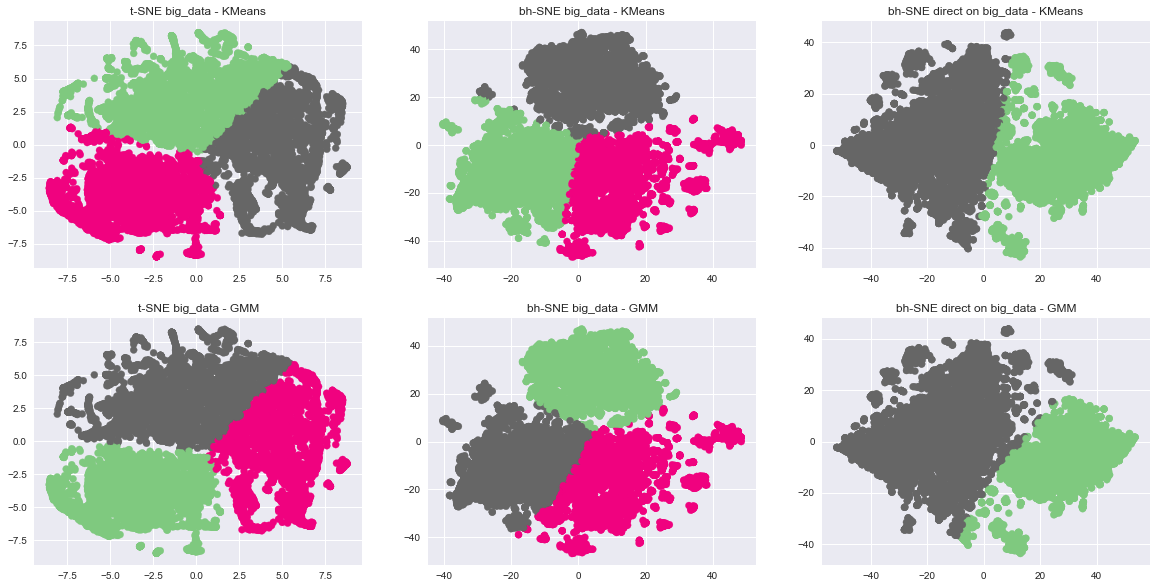

In [160]:
fig = plt.figure(figsize=(20,10))
plt.subplot2grid((2,3), (0,0))
plt.title('t-SNE big_data - KMeans')
plt.scatter(dr_tbd10_result[:,0], dr_tbd10_result[:,1], c=labels1, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (1,0))
plt.title('t-SNE big_data - GMM')
plt.scatter(dr_tbd10_result[:,0], dr_tbd10_result[:,1], c=labels2, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (0,1))
plt.title('bh-SNE big_data - KMeans')
plt.scatter(dr_bhbd10_result[:,0], dr_bhbd10_result[:,1], c=labels3, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (1,1))
plt.title('bh-SNE big_data - GMM')
plt.scatter(dr_bhbd10_result[:,0], dr_bhbd10_result[:,1], c=labels4, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (0,2))
plt.title('bh-SNE direct on big_data - KMeans')
plt.scatter(bhbd10_result[:,0], bhbd10_result[:,1], c=labels5, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (1,2))
plt.title('bh-SNE direct on big_data - GMM')
plt.scatter(bhbd10_result[:,0], bhbd10_result[:,1], c=labels6, cmap=plt.cm.get_cmap("Accent", 4))
plt.show()

### Observation
The clusters are not very well shaped but there is some formation apparent. Looking at the plots the data treated with the TruncateSVD dimensionality reduction seems to have formed better than when the bh-SNE was applied directly to the data. We can see a slight difference between the KMeans and GMM clusters and hard to tell which one captures the data better.

### Lets take a look at the manually merged data.

In [152]:
%%time

n_clusters = 3
km = KMeans(n_clusters)
clusters7 = km.fit_predict(dr_ttd10_result)
labels7 = km.labels_

CPU times: user 342 ms, sys: 8.69 ms, total: 351 ms
Wall time: 268 ms


In [153]:
%%time

clusterer8 = GMM(n_components=3, random_state=2).fit(dr_ttd10_result)
labels8 = clusterer8.predict(dr_ttd10_result)

CPU times: user 93 ms, sys: 2.96 ms, total: 96 ms
Wall time: 53.5 ms


In [154]:
%%time

n_clusters = 4
km = KMeans(n_clusters)
clusters9 = km.fit_predict(dr_bhtd10_result)
labels9 = km.labels_

CPU times: user 308 ms, sys: 6.68 ms, total: 314 ms
Wall time: 185 ms


In [155]:
%%time

clusterer10 = GMM(n_components=4, random_state=2).fit(dr_bhtd10_result)
labels10 = clusterer10.predict(dr_bhtd10_result)

CPU times: user 185 ms, sys: 5.63 ms, total: 191 ms
Wall time: 123 ms


In [156]:
%%time

n_clusters = 4
km = KMeans(n_clusters)
clusters11 = km.fit_predict(bhtd10_result)
labels11 = km.labels_

CPU times: user 405 ms, sys: 7.41 ms, total: 412 ms
Wall time: 229 ms


In [157]:
%%time

clusterer12 = GMM(n_components=4, random_state=2).fit(bhtd10_result)
labels12 = clusterer12.predict(bhtd10_result)

CPU times: user 106 ms, sys: 3.2 ms, total: 109 ms
Wall time: 59.6 ms


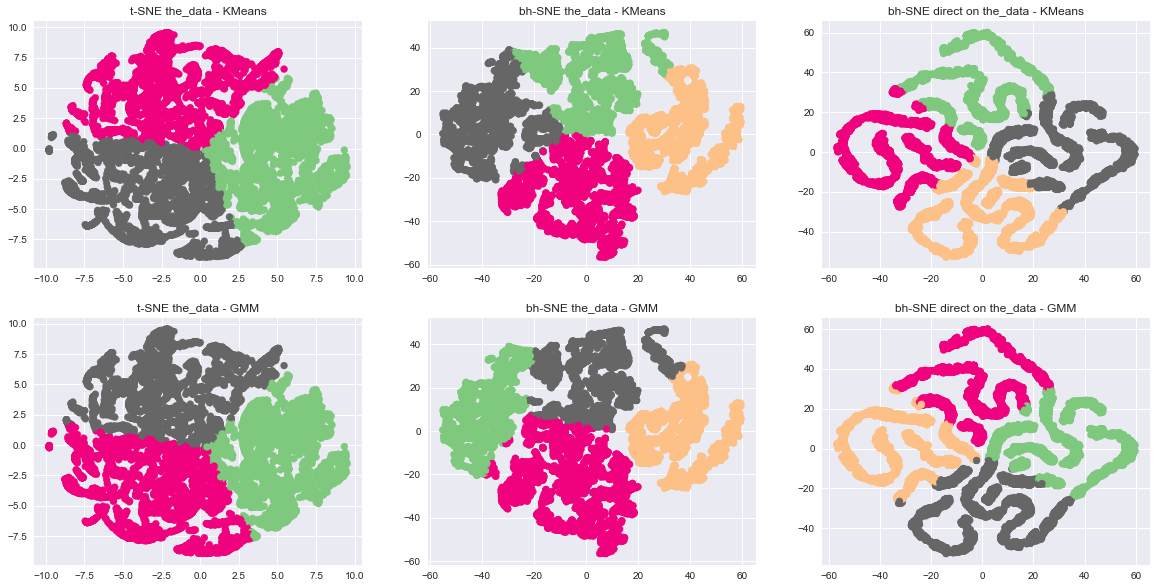

In [159]:
fig = plt.figure(figsize=(20,10))
plt.subplot2grid((2,3), (0,0))
plt.title('t-SNE the_data - KMeans')
plt.scatter(dr_ttd10_result[:,0], dr_ttd10_result[:,1], c=labels7, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (1,0))
plt.title('t-SNE the_data - GMM')
plt.scatter(dr_ttd10_result[:,0], dr_ttd10_result[:,1], c=labels8, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (0,1))
plt.title('bh-SNE the_data - KMeans')
plt.scatter(dr_bhtd10_result[:,0], dr_bhtd10_result[:,1], c=labels9, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (1,1))
plt.title('bh-SNE the_data - GMM')
plt.scatter(dr_bhtd10_result[:,0], dr_bhtd10_result[:,1], c=labels10, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (0,2))
plt.title('bh-SNE direct on the_data - KMeans')
plt.scatter(bhtd10_result[:,0], bhtd10_result[:,1], c=labels11, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((2,3), (1,2))
plt.title('bh-SNE direct on the_data - GMM')
plt.scatter(bhtd10_result[:,0], bhtd10_result[:,1], c=labels12, cmap=plt.cm.get_cmap("Accent", 4))
plt.show()

### Observation
It is interesting to see the difference in the clustering. The clusters seem more separated and a bit better formed. Despite that we will continue working with the `big_data` to see how the algorithm handles the original data.

# Bigger data<a name='big'></a>
bh_SNE on the dimensionality reduced data has the shortest wall time. GMM clusterer has also the shortest wall time and judging from the scatter plots, results in convincing visualizations. 

Now we have a better idea of what is the fastest method and what seems to be performing acceptable. Lets bring in a bigger dataset and see if our result change. We will use the bh-SNE dimensionality reduced data with the GMM clusterer on `big_data`.

## 'big_data'

In [3]:
%%time
svd = TruncatedSVD(algorithm='arpack', n_components=100)
dr_bd = normalize(svd.fit_transform(big_data), norm='l1')

CPU times: user 46.3 s, sys: 3.99 s, total: 50.3 s
Wall time: 32.5 s


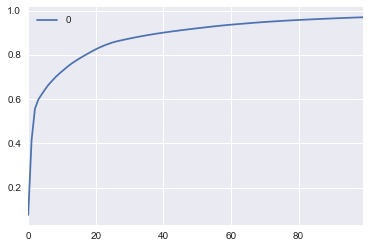

In [4]:
pd.DataFrame(np.cumsum(svd.explained_variance_ratio_)).plot()

In [5]:
%%time

result = bh_sne(dr_bd)

CPU times: user 44min 26s, sys: 43.1 s, total: 45min 9s
Wall time: 45min 50s


In [153]:
#pd.DataFrame(result).to_csv('bd.csv')

In [42]:
#result = pd.read_csv('bd.csv')

In [31]:
%%time

n_clusters = 3
km = KMeans(n_clusters)
clusters = km.fit_predict(result)
labels = km.labels_

CPU times: user 3.41 s, sys: 453 ms, total: 3.86 s
Wall time: 3.57 s


In [40]:
%%time

clusterer = GMM(n_components=3, random_state=2).fit(result)
labelss = clusterer.predict(result)

CPU times: user 1.25 s, sys: 199 ms, total: 1.45 s
Wall time: 1.28 s


In [35]:
%%time
db = DBSCAN(eps=0.8, min_samples=5).fit(result)
core_samples = db.core_sample_indices_
labels_dbscan = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print n_clusters_

3
CPU times: user 13.3 s, sys: 1.22 s, total: 14.5 s
Wall time: 14.9 s


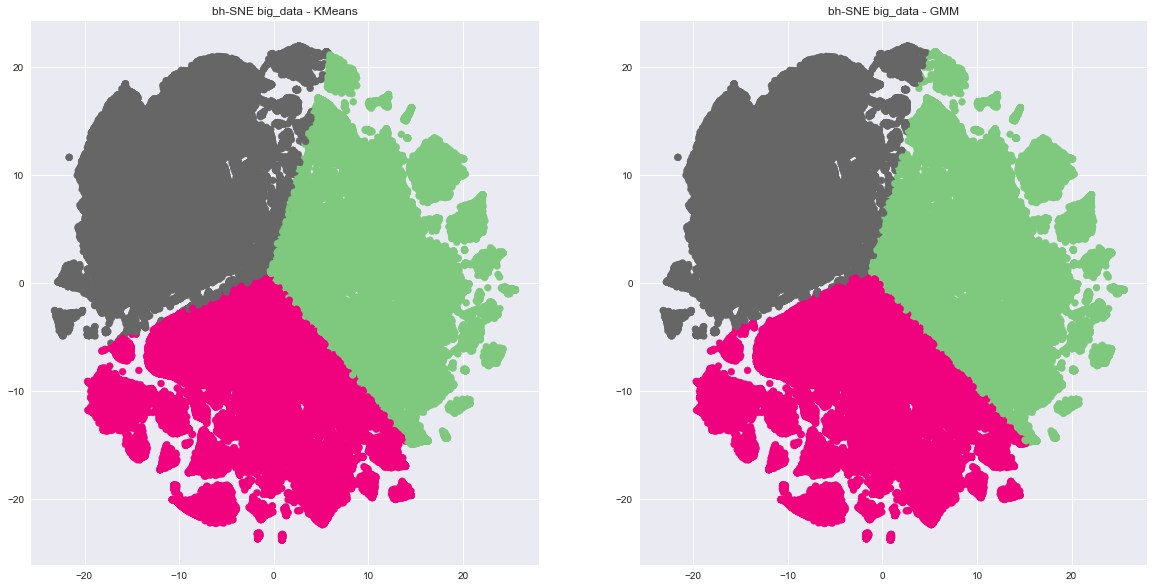

In [33]:
fig = plt.figure(figsize=(20,10))
plt.subplot2grid((1,2), (0,0))
plt.title('bh-SNE big_data - KMeans')
plt.scatter(result[:,0], result[:,1], c=labels, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((1,2), (0,1))
plt.title('bh-SNE big_data - GMM')
plt.scatter(result[:,0], result[:,1], c=labelss, cmap=plt.cm.get_cmap("Accent", 4))
plt.show()

### Observation 
There is not much difference between the KMeans and GMM. Lets take a closer look at the GMM big_data to see if there are any clusters.

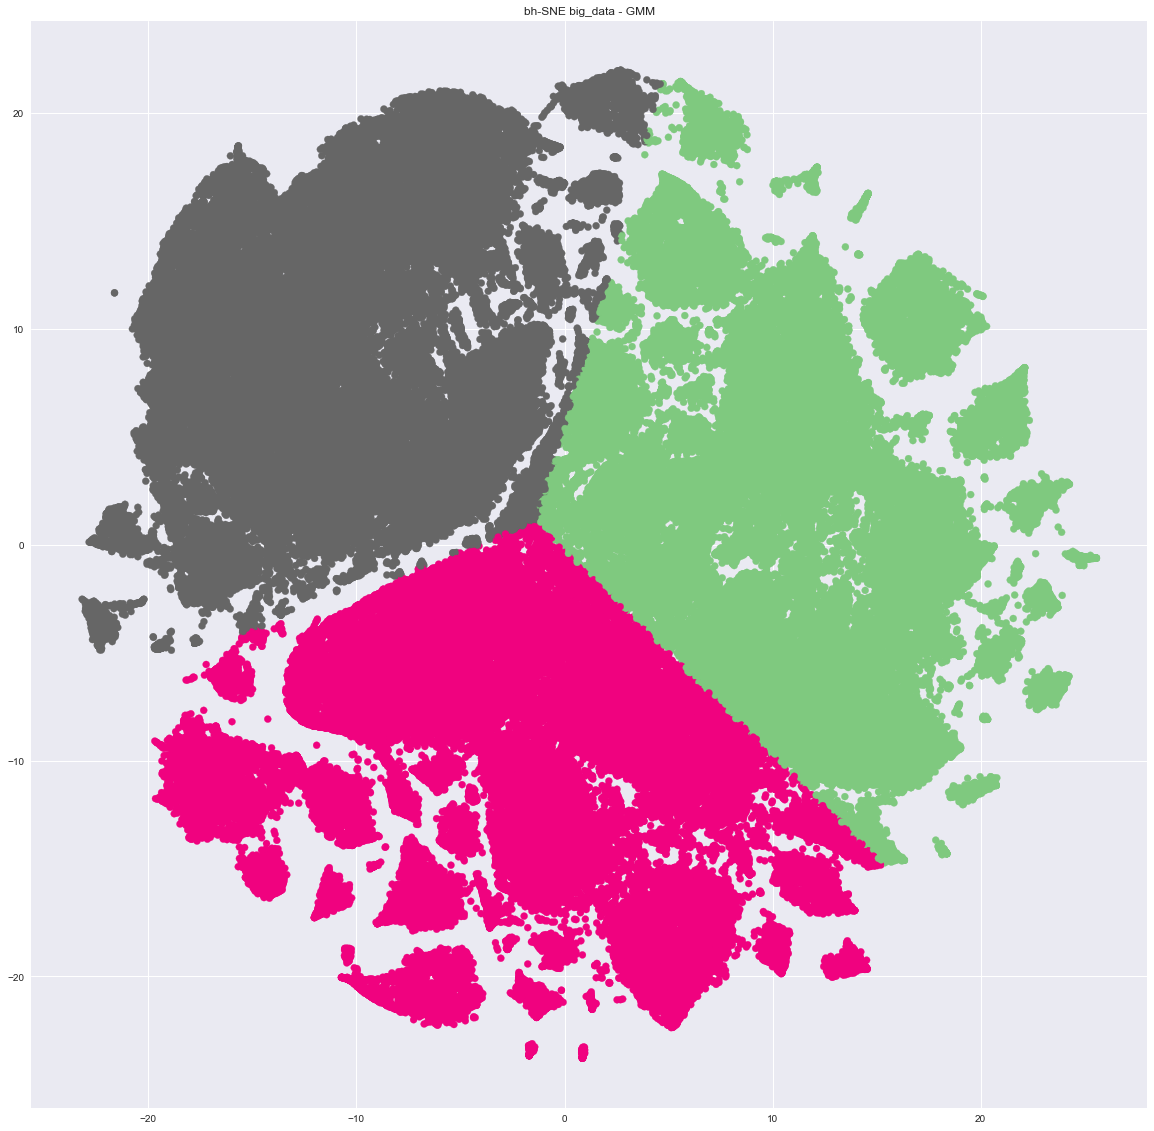

In [41]:
fig = plt.figure(figsize=(20,20))
plt.title('bh-SNE big_data - GMM')
plt.scatter(result[:,0], result[:,1], c=labelss, cmap=plt.cm.get_cmap("Accent", 4))

### Observation
There is some seperation but the GMM does not capture that preceisly. It looks more like there should be 2 clusters, the grey one and the pink and green one combined. This does not look like well defined clusters though.

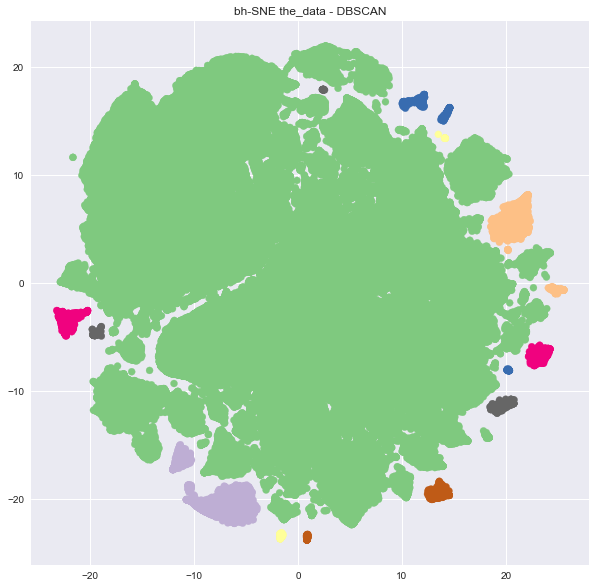

In [37]:
### Apply DBSCAN for some different cluster colors and amounts.
fig = plt.figure(figsize=(10,10))
plt.title('bh-SNE the_data - DBSCAN')
plt.scatter(result[:,0], result[:,1], c=labels_dbscan, cmap=plt.cm.get_cmap("Accent", 30))
plt.show()

### Observation
The DBSCAN certianly decides on different clusters but still not appealing enough.

## 'the_data'

In [11]:
%%time

result_td_raw = bh_sne(the_data)

CPU times: user 18min 13s, sys: 16.8 s, total: 18min 29s
Wall time: 18min 49s


In [11]:
#pd.DataFrame(result_td_raw).to_csv('td_raw.csv')

In [3]:
#imp_result_td_raw = pd.read_csv('td_raw.csv')
#print 'You have succsessfully imported result_td_raw'

You have succsessfully imported result_td_raw


In [26]:
%%time

n_clusters = 3
km = KMeans(n_clusters)
clusters15 = km.fit_predict(result_td_raw)
labels15 = km.labels_

CPU times: user 1.74 s, sys: 234 ms, total: 1.97 s
Wall time: 1.54 s


In [13]:
%%time

clusterer16 = GMM(n_components=4, random_state=2).fit(result_td_raw)
labels16 = clusterer16.predict(result_td_raw)

CPU times: user 1.45 s, sys: 194 ms, total: 1.65 s
Wall time: 1.12 s


In [14]:
%%time

db = DBSCAN(eps=0.8, min_samples=2).fit(result_td_raw)
core_samples = db.core_sample_indices_
labels_result_td_raw = db.labels_
nr_clusters_ = len(set(labels_result_td_raw)) - (1 if -1 in labels_result_td_raw else 0)
print nr_clusters_

57
CPU times: user 5.48 s, sys: 831 ms, total: 6.31 s
Wall time: 6.69 s


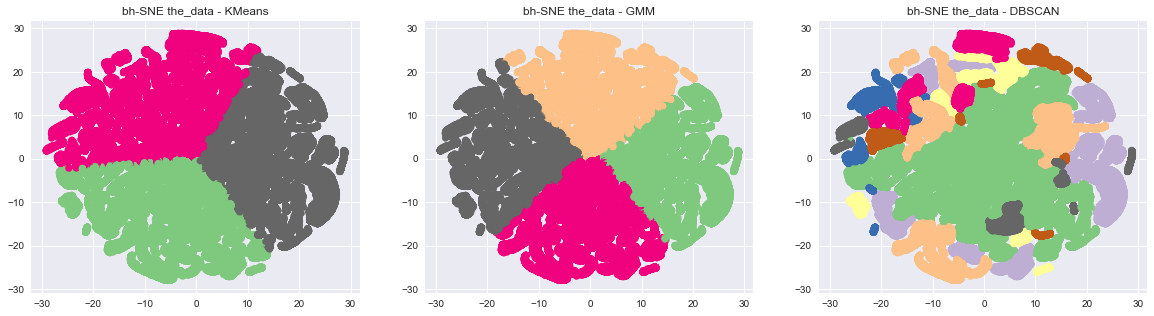

In [27]:
fig = plt.figure(figsize=(20,5))
plt.subplot2grid((1,3), (0,0))
plt.title('bh-SNE the_data - KMeans')
plt.scatter(result_td_raw[:,0], result_td_raw[:,1], c=labels15, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((1,3), (0,1))
plt.title('bh-SNE the_data - GMM')
plt.scatter(result_td_raw[:,0], result_td_raw[:,1], c=labels16, cmap=plt.cm.get_cmap("Accent", 4))
plt.subplot2grid((1,3), (0,2))
plt.title('bh-SNE the_data - DBSCAN')
plt.scatter(result_td_raw[:,0], result_td_raw[:,1], c=labels_result_td_raw, cmap=plt.cm.get_cmap("Accent", 50))
plt.show()

### Observation
There are obviusely more clusters forming with 'the_data' but KMeans and GMM have no sence on how to seperate them. DBSCN seems to be figuring something out though but the amount of clusters it is applying is a bit exessive - specially when there are only around 80 features to take into consideration.

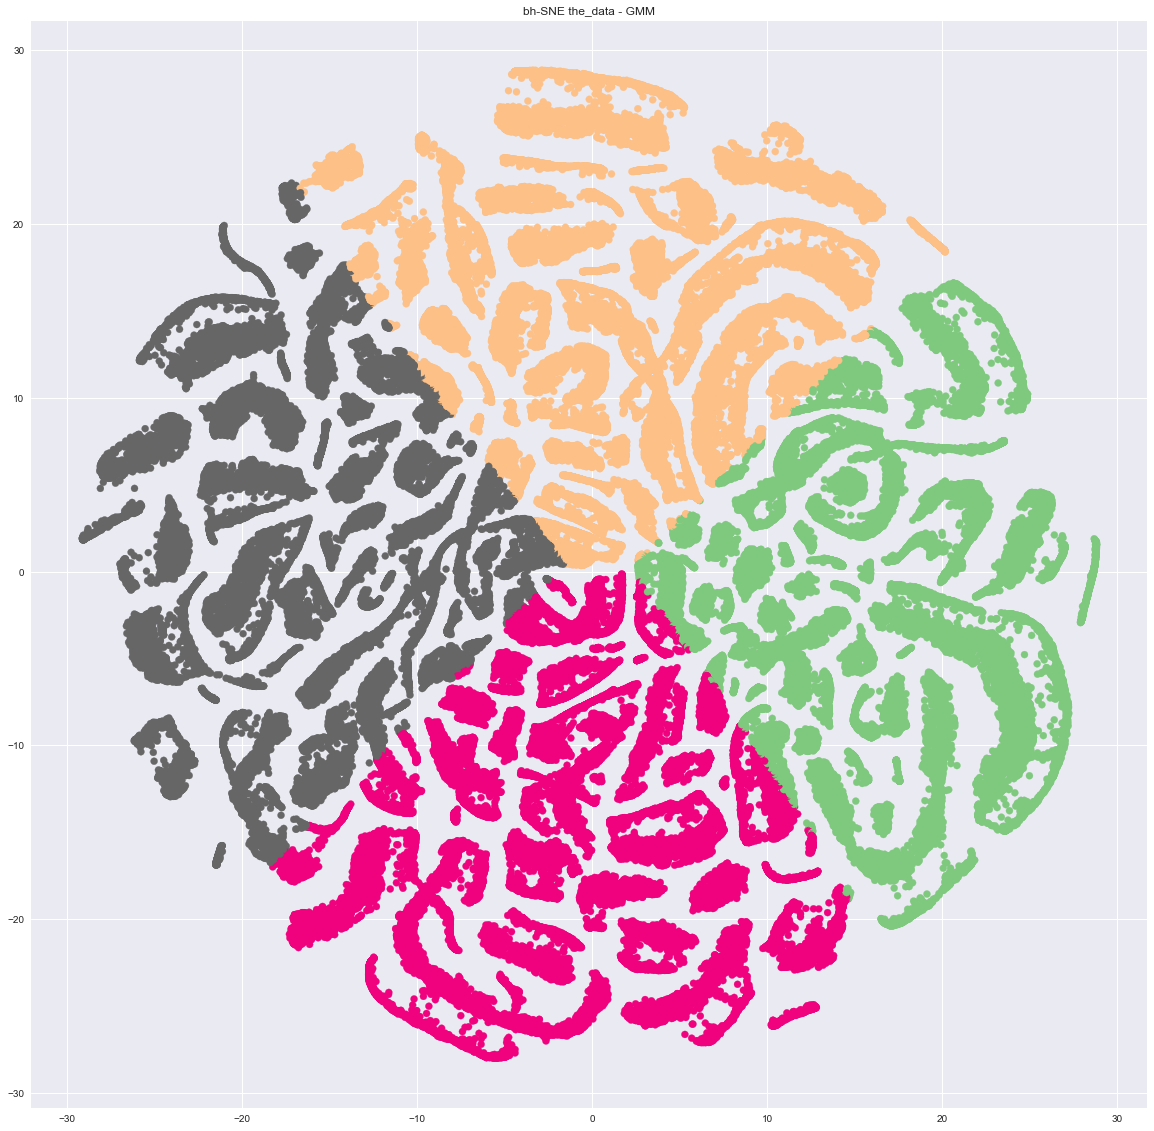

In [16]:
fig = plt.figure(figsize=(20,20))
plt.title('bh-SNE the_data - GMM')
plt.scatter(result_td_raw[:,0], result_td_raw[:,1], c=labels16, cmap=plt.cm.get_cmap("Accent", 4))

### Observation
The GMM follows no cluster formations at all. Lets try DBSCAN

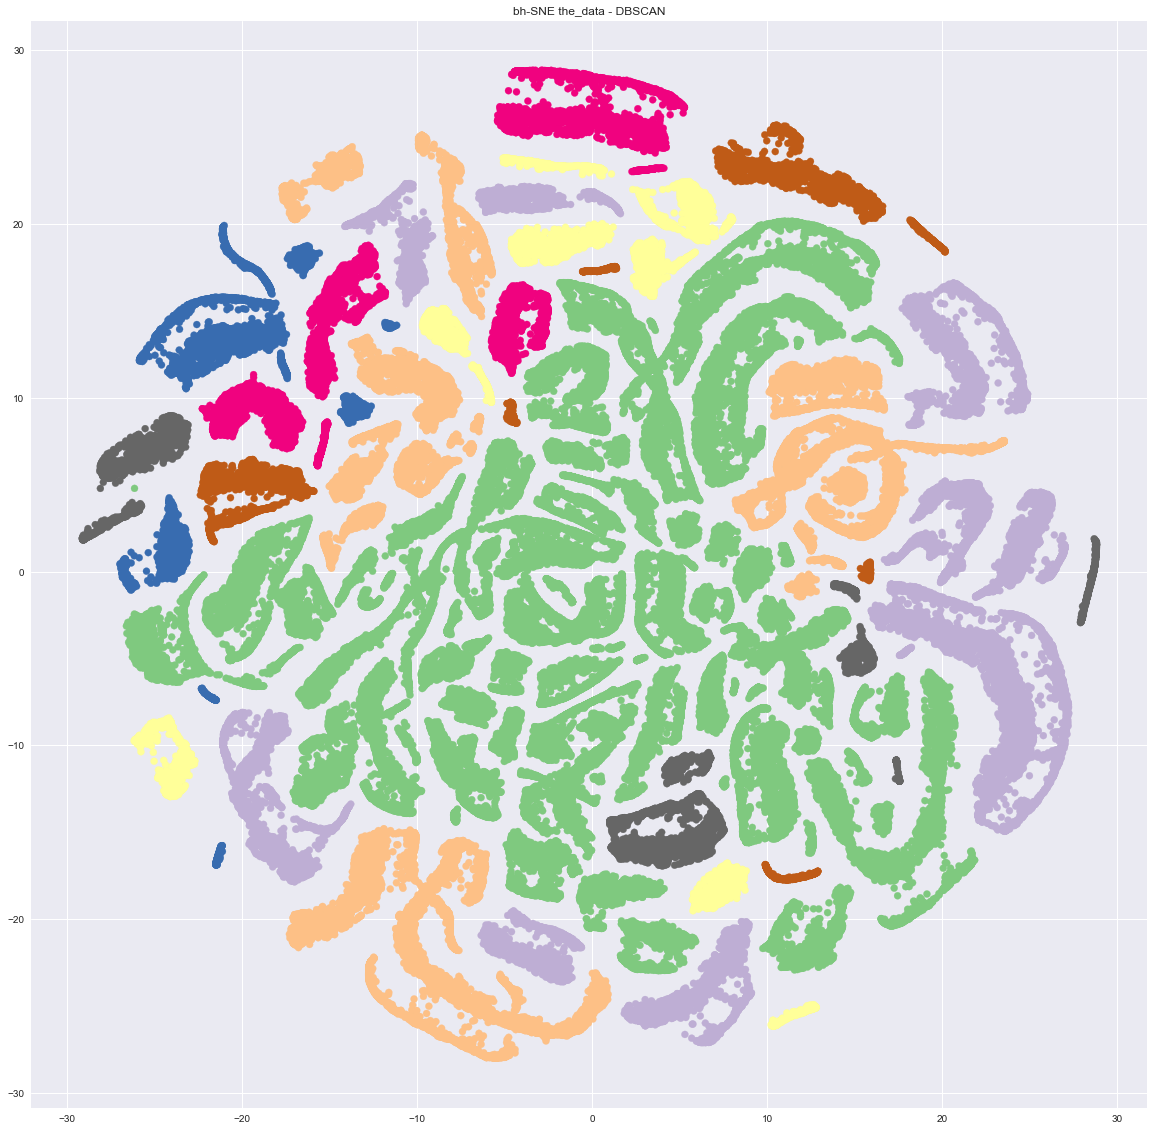

In [17]:
fig = plt.figure(figsize=(20,20))
plt.title('bh-SNE the_data - DBSCAN')
plt.scatter(result_td_raw[:, 0], result_td_raw[:, 1], c=labels_result_td_raw, cmap=plt.cm.get_cmap("Accent", 50))

### Observation
Since the manually merged dataset, without any formal dimensionality reduction, came out quite different in the clustering on the sample dataset we have plotted it by using the whole dataset, just out of curiosity. We were not able to run the silhouette score on the whole data so we tried using the highest score for the sample data. 

This plot comes out more cluster like than the other, there is the clusters are better separated. To be able to better capture the colors/divisions of the clusters it looks like we have to use a different cluster algorithm. 

## Benchmark model
There is no obvious methodology agains which I can benchmark and there for I will compare the visual results to the visual results of a more simple model, a PCA dimensionality reduced K-Means clustering model.

In [18]:
%%time
# Gives us vital information about the processing time

#Create the dimensionality reduction component
svd = TruncatedSVD(algorithm='arpack', n_components=100)

#Apply the dimensionality reduction component and normalize the outcome
dr_bd1000 = normalize(svd.fit_transform(big_data), norm='l1')

CPU times: user 44.2 s, sys: 3.17 s, total: 47.3 s
Wall time: 28.1 s


In [19]:
%%time
# Gives us vital information about the processing time

#Create the dimensionality reduction component
svd = TruncatedSVD(algorithm='arpack', n_components=5)

#Apply the dimensionality reduction component and normalize the outcome
dr_bd1001 = normalize(svd.fit_transform(the_data), norm='l1')

CPU times: user 1.55 s, sys: 235 ms, total: 1.79 s
Wall time: 1.17 s


In [20]:
%%time
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(dr_bd1000)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(dr_bd1000)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

CPU times: user 2.29 s, sys: 407 ms, total: 2.7 s
Wall time: 1.77 s


In [21]:
%%time
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(dr_bd1001)

# TODO: Transform the good data using the PCA fit above
reduced_the_data = pca.transform(dr_bd1001)

# Create a DataFrame for the reduced data
reduced_the_data = pd.DataFrame(reduced_the_data, columns = ['Dimension 1', 'Dimension 2'])

CPU times: user 378 ms, sys: 59.3 ms, total: 438 ms
Wall time: 270 ms


In [96]:
# It was to heavy to run the silhouette for the whole dataset 
# so I will be using the result for the 10,000 samples which is 2 and got 0,6233 in score.

#cluster_range = list(range(2,5)) 
#Go through with different n_components to find the best silhouette score

#for n_cluster in cluster_range:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    #clusterer = KMeans(n_cluster, random_state=2).fit(reduced_the_data)
    
    # Predict the cluster for each data point
    #preds = clusterer.predict(reduced_the_data)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    #score = silhouette_score(reduced_data, preds)
    
    #print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.623327736971
The score for n_cluster = 3. is : 0.566346636114
The score for n_cluster = 4. is : 0.520024298539


In [ ]:
# It was to heavy to run the silhouette for the whole dataset 
# so I will be using the result for the 10,000 samples which is 2 and got 0,6233 in score.
sreduced_the_data = reduced_the_data.sample(n = 10000)
cluster_range = list(range(2,5)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(sreduced_the_data)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(sreduced_the_data)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(sreduced_the_data, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.928678738225
The score for n_cluster = 3. is : 0.859065195705
The score for n_cluster = 4. is : 0.799096033098


In [22]:
%%time
clusterer = KMeans(2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
labelss = clusterer.labels_

CPU times: user 1.28 s, sys: 141 ms, total: 1.42 s
Wall time: 1.05 s


In [23]:
%%time
clustererr = KMeans(2).fit(reduced_the_data)
predss = clustererr.predict(reduced_the_data)
labelsss = clustererr.labels_

CPU times: user 1.37 s, sys: 189 ms, total: 1.56 s
Wall time: 1.19 s


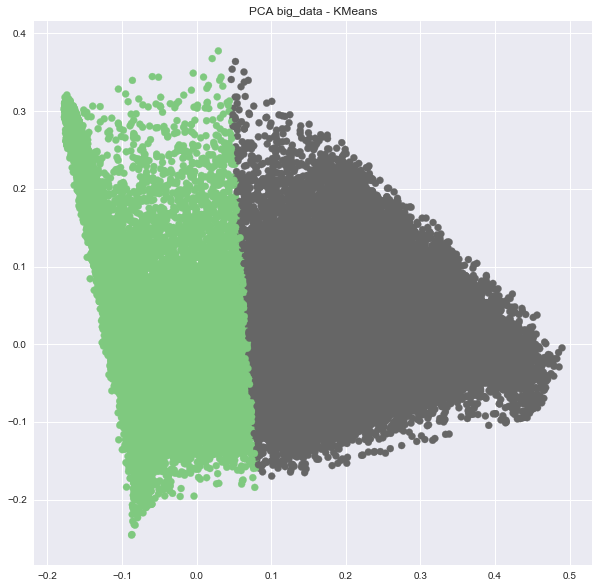

In [24]:
fig = plt.figure(figsize=(10,10))
plt.title('PCA big_data - KMeans')
plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], c=labelss, cmap=plt.cm.get_cmap('Accent', 4))

### Observation
This is a completely different demonstration. Even though the silhouette score is much higher, the visualisation forms no clusters at all.

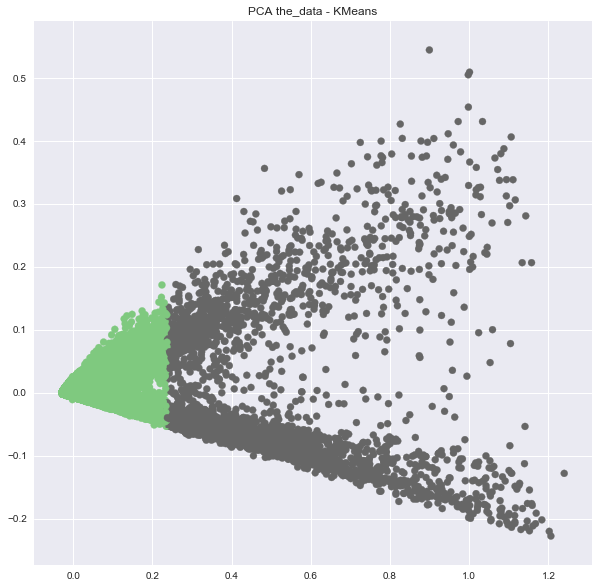

In [25]:
fig = plt.figure(figsize=(10,10))
plt.title('PCA the_data - KMeans')
plt.scatter(reduced_the_data['Dimension 1'], reduced_the_data['Dimension 2'], c=labelsss, cmap=plt.cm.get_cmap('Accent', 4))

### Observation
Same story here as with the 'big_data' but shows more seperation.

# Conclusion<a name='conclu'></a>

By using TruncatedSVD for dimensionality reduction, normalising the data, using bh-SNE to reduce it to a 2D array, cluster the data with GMM and finally plotting it with the cluster labels the algorithm has mapped a multi-dimensional problem into just two dimensions. It is not decisive enough to confirm that we can divide people into groups based on how they spend their 1440 minutes a day, even though we got some idea of cluster formations because the clusters did not separate well and had weak structures. 
 
It is interesting to see some form of clustering within the data and it looks like the manually merged data does a better job at clustering than the original data, which is not surprising due to less features. It would be interesting to label the sex, and age groups and see how they fit within the clusters. 
 
In whole, this was a good beginning on trying to categories the ATUS participants by their use of time.

**Improvement**  
There is still much information we did not include in the clustering, some things that might bet interesting to take into account, like weekdays vs weekends, male vs female, age and so on. Adding those features is an interesting next step. 
 
￼￼￼ 14 of  15
It would be better, for practical reasons, to use a method where it is possible to trace better where each participant ends up, one that can inverse transform. I did manage to use the hoover tool from plotly and get the participants index number but would like to explore other visualisation tools to get better result and include the cluster colors as well as the participants ID, without the whole thing crashing.  
 
The method used in this project is good for visual clustering and can therefore show if there are clusters or not. I would need better hardware to be able to calculate the Silhouette score for the whole data and with so few metrics to compare to and not having the Silhouette score for the bigger clusters makes this a project that needs further exploring.

### References <a name='ref'></a>

https://github.com/lvdmaaten/bhtsne

https://arxiv.org/pdf/1301.3342v2.pdf

http://scikit-learn.org/stable/modules/preprocessing.html

https://pdfs.semanticscholar.org/799e/4b1af2d26c1d99a1bac39487b00eb6e3a7cf.pdf

https://lvdmaaten.github.io/tsne/

https://github.com/datacratic/mtlpy50

https://www.authorea.com/users/94202/articles/110467-t-sne-visualization-of-large-scale-neural-recordings/_show_article